In [1]:
import pandas as pd
import time
import datetime
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit

In [2]:
# Read whole datasets
df = pd.read_csv("training_set_VU_DM.csv")
df_test = pd.read_csv("test_set_VU_DM.csv")

## Notes
- There are multiple search results for the same search id
- No. unique id's in the full training set is 199795, 175188 in the sample set
- Position, click_bool , booking_bool and gross_booking_usd is not included in test set! 

## Descriptive dataframe

In [4]:
# Make a descriptive dataframe
df_descr = pd.concat([df.nunique(), df.isna().sum(), df.notna().sum(), df.dtypes, df.max(), df.min()], axis=1)
df_descr.columns = ['Unique values', 'NaN count', 'non NaN count', 'Datatype', 'Max value', 'Min value']
df_descr

,Unique values,NaN count,non NaN count,Datatype,Max value,Min value
srch_id,199795,0,4958347,int64,332785,1
date_time,198615,0,4958347,object,2013-06-30 23:58:24,2012-11-01 00:08:29
site_id,34,0,4958347,int64,34,1
visitor_location_country_id,210,0,4958347,int64,231,1
visitor_hist_starrating,312,4706481,251866,float64,5.0,1.41
visitor_hist_adr_usd,7799,4705359,252988,float64,1958.7,0.0
prop_country_id,172,0,4958347,int64,230,1
prop_id,129113,0,4958347,int64,140821,1
prop_starrating,6,0,4958347,int64,5,0
prop_review_score,10,7364,4950983,float64,5.0,0.0


## Split numeric and categoric variables roughly , plot them

In [5]:
descr2 = df_descr[df_descr['Unique values'] <= 10].index.tolist() # (almost) all are categorical variables
descr3 = df_descr[df_descr['Unique values'] > 50].index.tolist() # (almost) all are numerical variables


#df[descr2].hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8)
descr3.remove('date_time')
descr3.remove('srch_id')
#df.boxplot(column=descr3, figsize=(16, 20))



array([[<AxesSubplot:title={'center':'prop_starrating'}>,
        <AxesSubplot:title={'center':'prop_review_score'}>,
        <AxesSubplot:title={'center':'prop_brand_bool'}>,
        <AxesSubplot:title={'center':'promotion_flag'}>,
        <AxesSubplot:title={'center':'srch_adults_count'}>],
       [<AxesSubplot:title={'center':'srch_children_count'}>,
        <AxesSubplot:title={'center':'srch_room_count'}>,
        <AxesSubplot:title={'center':'srch_saturday_night_bool'}>,
        <AxesSubplot:title={'center':'random_bool'}>,
        <AxesSubplot:title={'center':'comp1_rate'}>],
       [<AxesSubplot:title={'center':'comp1_inv'}>,
        <AxesSubplot:title={'center':'comp2_rate'}>,
        <AxesSubplot:title={'center':'comp2_inv'}>,
        <AxesSubplot:title={'center':'comp3_rate'}>,
        <AxesSubplot:title={'center':'comp3_inv'}>],
       [<AxesSubplot:title={'center':'comp4_rate'}>,
        <AxesSubplot:title={'center':'comp4_inv'}>,
        <AxesSubplot:title={'center':'comp5

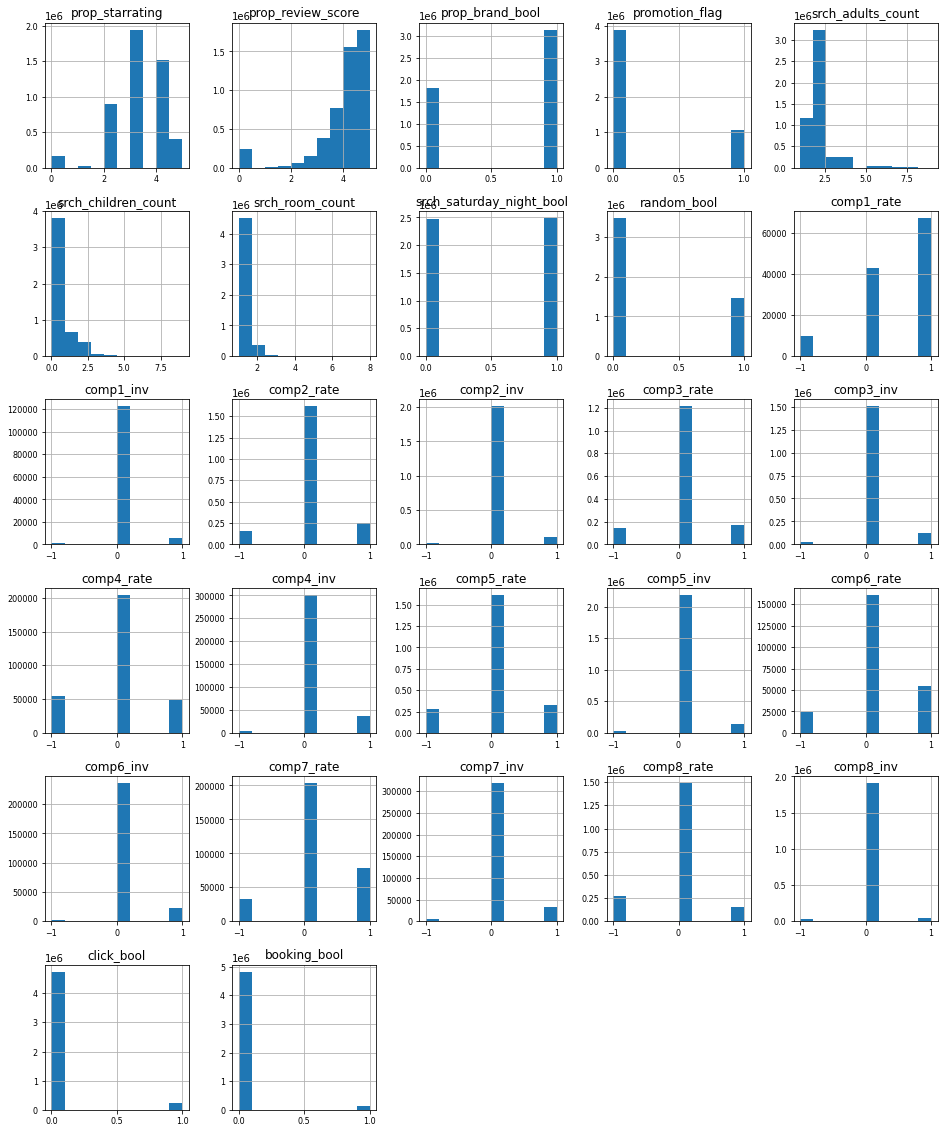

In [6]:
df[descr2].hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8)

<AxesSubplot:xlabel='date'>

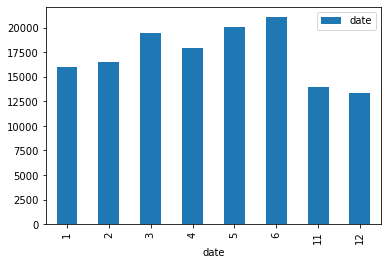

In [7]:
## Check if there is some relation between date time and booking

#split date time in date and time
df[['date', 'time']] = df['date_time'].str.split(' ', 1, expand=True)
df['date'] = pd.to_datetime(df['date'])

# Show booked items and in which month they occurred
df_only_booked = df[df['booking_bool']==1]
df_only_booked = df_only_booked[['date']]
df_only_booked.groupby(df_only_booked["date"].dt.month).count().plot(kind="bar", stacked=True)


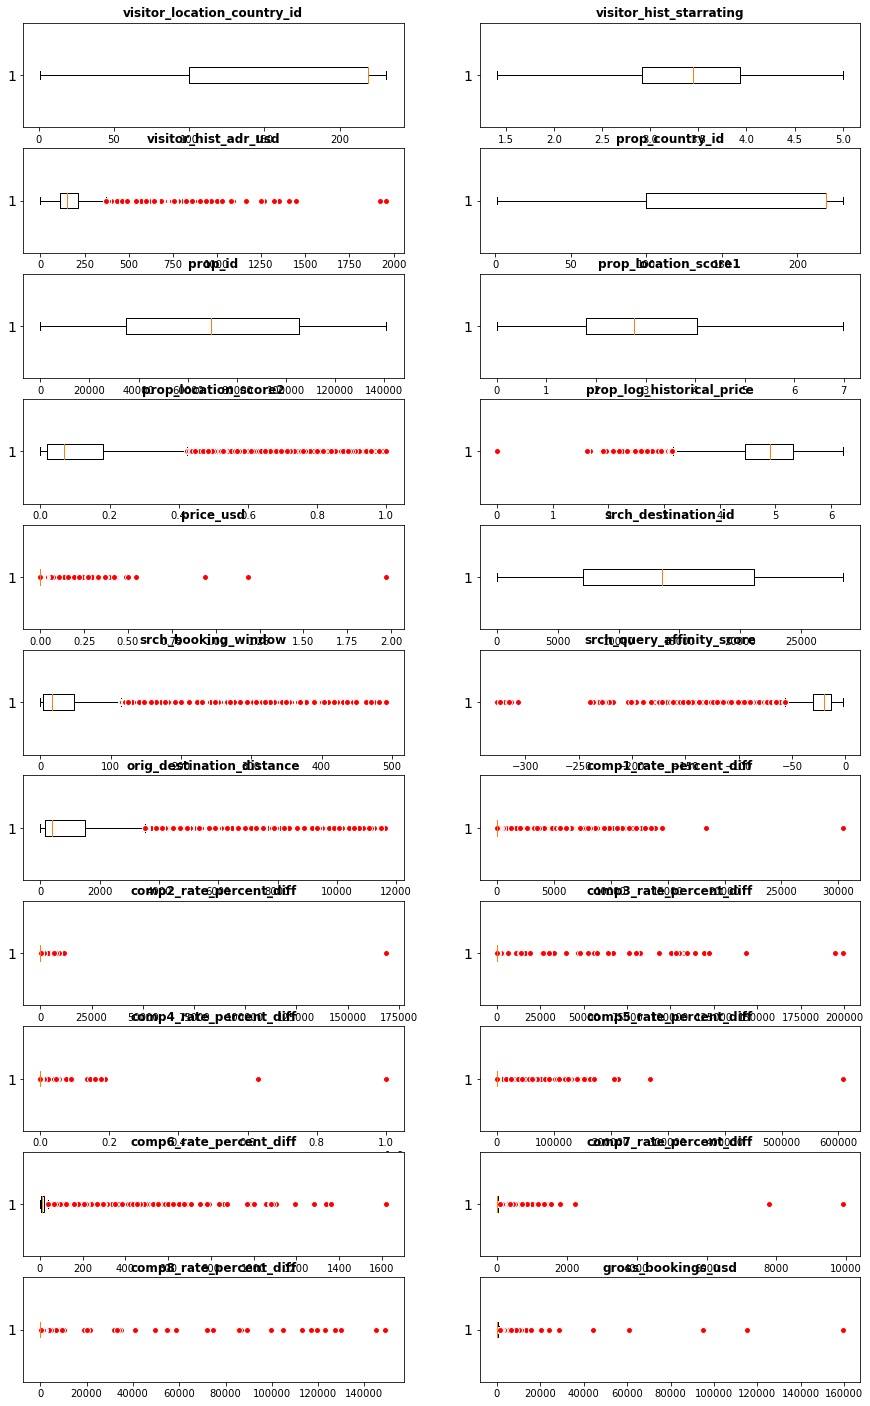

In [22]:
df_numerical = df[descr3]

red_circle = dict(markerfacecolor = 'red', marker = 'o', markeredgecolor = 'white')

fig, axs = plt.subplots(11, 2, figsize=(15,25))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df_numerical.iloc[:,i].dropna(), flierprops = red_circle, vert=False)
    ax.set_title(df_numerical.columns[i], fontweight = 'bold')
    ax.tick_params(axis = 'y', labelsize = 14)

plt.show()

In [10]:
# Show top 5 booked properties
df_top5_prop = df.groupby('prop_id').agg({'booking_bool': sum})
df_top5_prop = df_top5_prop.sort_values(['booking_bool'],ascending=False).head()
df_top5_prop

prop_id
104517    2357
124342    2355
68420     2285
40279     2275
134154    2257
Name: srch_id, dtype: int64


,booking_bool
prop_id,
116942,159
22578,140
77089,122
53494,117
137997,109


<ipython-input-11-7538a5879ba8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['booking_bool'] = df['booking_bool'].values


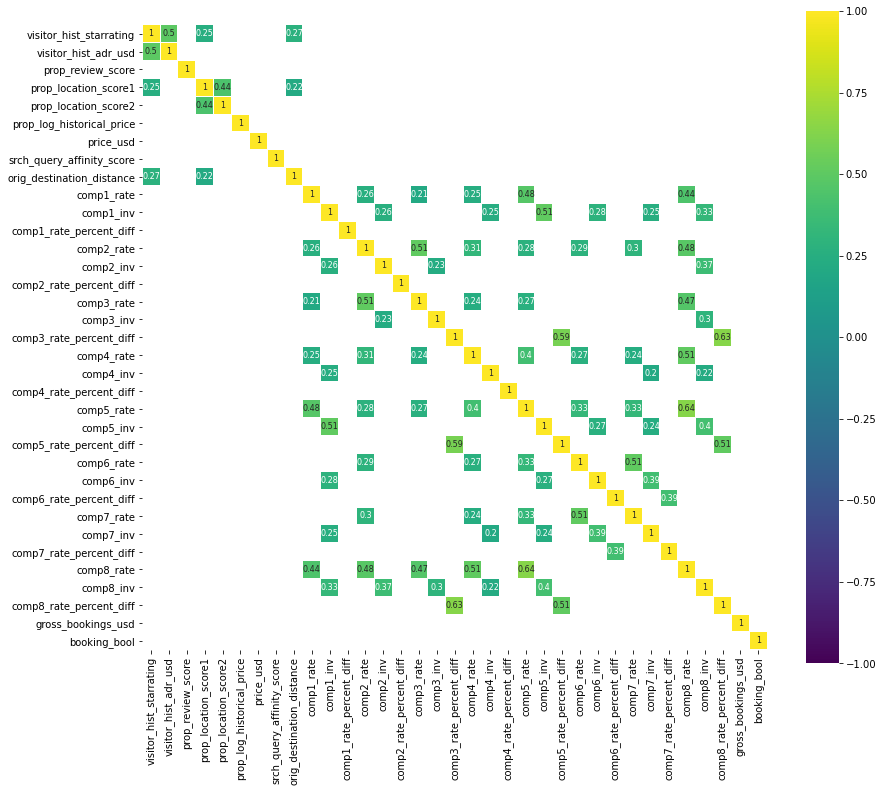

In [11]:
# Plot correlation matrix of all float values + booking or not
df_num = df.select_dtypes(include=[float])
df_num['booking_bool'] = df['booking_bool'].values
corr = df_num.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr[(corr >= 0.2) | (corr <= -0.2)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);


https://towardsdatascience.com/learning-to-rank-with-python-scikit-learn-327a5cfd81f

In [12]:
#df = pd.read_csv("test_set_VU_DM.csv")
#df

## Tried naive bayes , didnt really work, but did get result format
#### See https://medium.com/predictly-on-tech/learning-to-rank-using-xgboost-83de0166229d

## Naive bayes trial

In [13]:
from sklearn.naive_bayes import MultinomialNB
pd.options.mode.chained_assignment = None  # default='warn'

X_train = df.loc[:, df.columns.isin(['prop_starrating', 'prop_brand_bool', 'prop_location_score1',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
       'random_bool'])]
y_train = df.loc[:, df.columns.isin(['booking_bool'])]

X_test = df_test.loc[:, df_test.columns.isin(['prop_starrating', 'prop_brand_bool', 'prop_location_score1',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
       'random_bool'])]
y_test = df_test.loc[:, df_test.columns.isin(['booking_bool'])]

clf = MultinomialNB()
clf.fit(X_train, y_train.values.ravel())
NB_result = clf.predict(X_train)
score = clf.score(X_train, y_train, sample_weight=None)
NB_prob = clf.predict_proba(X_train)

print('Accuracy Training: ', score)
print(clf.classes_)
print(NB_prob[:,1]) # Probabilities of being booked
df_train_result = df[['srch_id', 'prop_id', 'booking_bool']]
df_train_result['booking_pred'] = NB_result
df_train_result['booking_pred_prob'] = NB_prob[:,1]
df_sorted = df_train_result.sort_values(["srch_id", "booking_pred_prob"], ascending=[True, False])
df_sorted[['srch_id', 'prop_id']]

Accuracy Training:  0.8664550907792455
[0 1]
[0.06918335 0.29176339 0.33185999 ... 0.0079927  0.02143285 0.00307976]


,srch_id,prop_id
3,1,27348
9,1,56880
13,1,74474
5,1,30184
19,1,89073
...,...,...
4958342,332785,77700
4958341,332785,55110
4958344,332785,94508
4958343,332785,88083


In [15]:
## Now for test csv

NB_prob_t = clf.predict_proba(X_test)
#print(NB_prob_t[:,1]) # Probabilities of being booked

df_test_result = df_test[['srch_id', 'prop_id']]
df_test_result['booking_pred_prob'] = NB_prob_t[:,1]
df_sorted = df_test_result.sort_values(["srch_id", "booking_pred_prob"], ascending=[True, False])
final_frame = df_sorted[['srch_id', 'prop_id']]
#final_frame
# header "SearchId ,PropertyId" 
np.savetxt(r'group93.txt', final_frame.values , fmt='%d')
final_frame.to_csv('group93.csv', index=False)
final_frame

,srch_id,prop_id
28,1,139162
17,1,78599
15,1,73666
10,1,56050
3,1,22393
...,...,...
4959180,332787,35240
4959177,332787,29018
4959179,332787,33959
4959178,332787,32019


## XGBoost

In [20]:
X_train = df.loc[:, df.columns.isin(['prop_starrating', 'prop_brand_bool', 'prop_location_score1',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
       'random_bool'])]
y_train = df.loc[:, df.columns.isin(['booking_bool'])]

# read in data
# specify parameters via map

# X_train[['prop_starrating', 'prop_brand_bool', 'prop_location_score1', 'promotion_flag',
#        'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
#        'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
#        'random_bool']].astype("category")


# Maybe set up category x_train to increase performance - xgb.XGBClassifier (enable_categorical=True,)

clf2 = xgb.XGBClassifier( use_label_encoder=False)
# X is the dataframe we created in previous snippet
clf2.fit(X_train, y_train)
score = clf2.score(X_train, y_train, sample_weight=None)
print('Accuracy Training: ', score)
XGB_prob = clf2.predict_proba(X_train)

print("Booked or not:", clf2.classes_)
print("Probabilities of being booked:", XGB_prob[:,1])
df_train_result = df[['srch_id', 'prop_id', 'booking_bool']]
df_train_result['booking_pred_prob'] = XGB_prob[:,1]
df_sorted = df_train_result.sort_values(["srch_id", "booking_pred_prob"], ascending=[True, False])
df_sorted[['srch_id', 'prop_id']]


Accuracy Training:  0.9720892870144022
Accuracy Training:  0.9720892870144022
[0 1]
[0.01001715 0.00750412 0.00414906 ... 0.04502364 0.03824653 0.04847757]


,srch_id,prop_id
16,1,88096
18,1,88218
11,1,59526
21,1,95307
8,1,53341
...,...,...
4958346,332785,134949
4958344,332785,94508
4958341,332785,55110
4958342,332785,77700


In [21]:
## Now for test csv
XGB_prob_t = clf2.predict_proba(X_test)
#print(NB_prob_t[:,1]) # Probabilities of being booked

df_test_result = df_test[['srch_id', 'prop_id']]
df_test_result['booking_pred_prob'] = XGB_prob_t[:,1]
df_sorted = df_test_result.sort_values(["srch_id", "booking_pred_prob"], ascending=[True, False])
final_frame = df_sorted[['srch_id', 'prop_id']]
#final_frame
# header "SearchId ,PropertyId" 
final_frame.to_csv('xgb_group93.csv', index=False)
final_frame

,srch_id,prop_id
23,1,99484
9,1,54937
12,1,61934
22,1,95031
8,1,50162
...,...,...
4959177,332787,29018
4959176,332787,22854
4959178,332787,32019
4959180,332787,35240
